### 교보문고 크롤링 프로젝트: 책 추천 시스템
- 수집 사이트: 교보문고(www.kyobobook.co.kr), 서지정보센터
- 수집 동기: 국내 최대 도서 유통 사이트의 베스트셀러 분석
- 목표: 크롤링한 데이터를 데이터베이스에 저장 후 베스트셀러 분석 및 도서 추천 시스템 제공 

- 가설: 
    - 1. 장르별로 책 사이즈가 다를 것이다
    - 2. 주요 출판사일수록 리뷰 수가 많을 것이다
    - 3. 소설 분야에서 가장 많은 세부장르는 한국문학일 것이다
- 컬럼 소개:
    - category : 카테고리(장르), 
    - ranking: 해당 카테고리 내 베스트셀러 순위, 
    - seogi_nl_clear: 국립중앙박물관 서지정보센터에 등록된 도서 장르 부가기호, 
    - ISBN: 국가에 등록된 도서 고유 번호
    - title_x: 도서 제목, 
    - author: 저자 이름, 
    - publisher: 출판사, 
    - price_x: 가격, 
    - width, length, thick, weight: 가로(mm), 세로(mm), 두께(mm), 무게(g), 
    - page: 쪽 수, 
    - grade: 구매한 독자들이 남긴 점수의 총 점(각 1~5점), 
    - grade_count: 구매한 독자들이 남긴 리뷰 개수, 
    - summary_x: 출판사들이 교보문고에 제출한 책 소개, 저자 소개, 목차 텍스트 모음, 
    - review: 독자들이 남긴 리뷰 텍스트 모음

In [69]:
import seaborn as sns
import pandas as pd
import re
import matplotlib as mpl
from matplotlib import rc
#import missingno as msno
import warnings
import datetime
import matplotlib.pyplot as plt
#import statsmodels.api as sm
warnings.filterwarnings('ignore')

# matplotlib 한글 사용을 위한 코드
rc('font', family='AppleGothic')
mpl.rc('font', family='Hancom Gothic')
mpl.rc('axes', unicode_minus=False)

from IPython.display import Image

#정규표현식
import re
import string

### content 데이터 로딩

In [12]:
#몽고db에서 크롤링한 데이터 가져오기
import pymongo

client = pymongo.MongoClient('mongodb://ID:PW@IP:PORT')
db = client.kyobo
collection = db.book

In [13]:
df_book = pd.DataFrame(collection.find({}, {"_id": False}))

In [14]:
len(df_book)

10245

In [15]:
df_book.to_csv('./Crwling_Kyobo_Content.csv')

#### 전처리
- 문자형에서 정수형으로 바꿀 컬럼: 
    - price: 원 제거
    - page_count: 쪽 제거
    - width: 가로 
    - length: 세로
    - thick: 두께, mm 제거
    - weight: 무게, g 제거
- 정수형에서 문자형으로 바꿀 컬럼: 
    - category

In [16]:
# 중복된 데이터 거르기
df_book =  pd.read_csv('./Crwling_Kyobo_Content.csv', index_col=0)
df_book2 = df_book.drop_duplicates(["ISBN"], keep='last')
df_book3 = df_book2.reset_index().drop('index', axis=1)

In [17]:
len(df_book2)

3952

In [18]:
df_book3["publisher"] = df_book3["publiser"]

In [9]:
#size컬럼에서 가로 * 세로 * 두께 * 무게를 각 컬럼으로 분리 한다
widths = []
lengths = []
thicknesss = []
weights = []
for i in range(len(df_book3)):
    width = df_book3["size"][i][0:3]
    length = df_book3["size"][i][6:9]
    thickness = df_book3["size"][i][12:15]
    weight = df_book3["size"][i][19:]
    
    widths.append(width)
    lengths.append(length)
    thicknesss.append(thickness)
    weights.append(weight)

In [10]:
df_book3["width"] = widths
df_book3["length"] = lengths
df_book3["thick"] = thicknesss
df_book3["weight"] = weights

In [ ]:
# price 컬럼에서 단위 '원' 제거 
prices = []
for i in range(len(df_book3)):
    price = df_book3["price"][i][:-1]
    prices.append(price)

df_book3["price(원)"] = prices

In [ ]:
df_book3["price"] = df_book3["price(원)"]

In [ ]:
# page_count 컬럼에서 단위 '쪽' 제거
pages = []
for i in range(len(df_book3)):
    page = df_book3["page_count"][i][:-1]
    pages.append(page)

df_book3["page(쪽)"] = pages

In [ ]:
# weight 컬럼에서 단위 'g' 제거
weights = []
for i in range(len(df_book3)):
    weight = df_book3["weight"][i][:-3]
    weights.append(weight)

df_book3["weight(g)"] = weights

In [ ]:
df_book3["weight"] = df_book3["weight(g)"]

In [ ]:
# price 컬럼에서 실수형 변환을 위해 콤마(,) 삭제 
df_book3["price"] = df_book3["price"].str.replace(",", "")

In [ ]:
df_book3 = df_book3.fillna(0)

In [ ]:
# thick은 너무 잘못된 게 많아서 버림
#df_book3["thick"].astype(int)

In [ ]:
msno.matrix(df_book3, figsize=(16, 8))
plt.show()

In [ ]:
df_book3["width"]= df_book3[["width"]].astype(int)
df_book3["length"] = df_book3[["length"]].astype(int)
df_book3["price"] = df_book3["price"].astype(int)
df_book3["page(쪽)"] = df_book3["page(쪽)"].astype(int)
df_book3["weight"] = df_book3["weight"].astype(int)

In [ ]:
columns = ["category", "barcode", "title", "author",  "publisher", "size", "width", "length", "thick", "weight", "page(쪽)",  "price", "summary"]
df_book3 = df_book3[columns]
df_book3

In [ ]:
df_book3.info()

In [ ]:
df_book3.describe()

### review 데이터 로딩

In [ ]:
import pymongo

client = pymongo.MongoClient('mongodb://ID:PW@IP:PORT')
db = client.kyobo
collection2 = db.review

In [ ]:
df_review = pd.DataFrame(collection2.find({}, {"_id": False}))

In [ ]:
len(df_review)

In [ ]:
df_review.isnull().sum()

In [ ]:
msno.matrix(df_review, figsize=(16, 8))
plt.show()

#### 전처리
- grade 

In [ ]:
df_review['grade'] = df_review['grade'].replace("\n", "").replace("\t", "").replace("\n\t\t\t\t\t                       ", "").replace("", "").replace("'", "")
df_review['grade'] = df_review['grade'].fillna(0)
df_review.to_csv("./df_review_temp.csv")
df_review = pd.read_csv("./df_review_temp.csv", encoding="utf-8", index_col=0)

In [ ]:
grade_ints =  []

for i in range(len(df_review)):
    grade_int = int(df_review['grade'][i])
    grade_ints.append(grade_int)
    
grade_ints

In [ ]:
df_review['grade'].astype(int)

In [ ]:
df_review['grade_count'] = df_review['grade']

In [ ]:
joined_df_review = df_review.groupby('ISBN').agg({'grade_count' : 'count','grade' : 'sum', 'review' : lambda x : ' '.join(x)})

In [ ]:
joined_df_review

In [ ]:
joined_df_review_temp = joined_df_review.grade.reset_index(name = "grade")
joined_df_review_temp["review"] = joined_df_review["review"].reset_index(name = "review").review
joined_df_review_temp["grade_count"] = joined_df_review["grade_count"].reset_index(name = "grade_count").grade_count
joined_df_review_temp

In [ ]:
len(joined_df_review_temp)

In [ ]:
joined_df_review_temp.columns

### 서지정보센터 부가기호 데이터 수집

In [ ]:
df_seogi_num = pd.read_csv("./seogi_num.csv", index_col=0)
df_seogi_num

In [ ]:
seogis = []

for i in range(len(df_seogi_num)):
    seogi = df_seogi_num["seogi_nl"][i][-6:-1]
    re.findall("[0-9]{5}", seogi)

    seogis.append(seogi)

In [ ]:
df_seogi_num["seogi_nl_clear"] = seogis

In [ ]:
df_seogi_num

### 베스트셀러 등수 데이터 수집

In [ ]:
df_rankings = pd.read_csv("./Kyobo_Crawling_ranking.csv", index_col=0)
df_rankings.reset_index(inplace=False)
df_rankings

In [ ]:
df_book3["ISBN"] = df_book3["barcode"]

### 최종 데이터 합치기
- content 데이터
- review 데이터
- 서지정보센터 부가기호 데이터
- 베스트셀러 카테고리별 순위

In [ ]:
mergedStuff = pd.merge(df_book3, df_seogi_num, on=['ISBN'], how='inner')
df_bestsellors = pd.merge(mergedStuff, joined_df_review_temp, on=['ISBN'], how='inner')


In [ ]:
df_bestsellor2 = pd.merge(df_bestsellors,df_rankings, on=['ISBN'], how='inner')
df_bestsellor3 = pd.merge(df_bestsellor2, df_book2, on=["ISBN"], how='inner')


In [ ]:
columns = ["category", "ranking", "seogi_nl_clear", "ISBN", "title_x", "author", "publisher", "price_x",
           "width", "length", "thick", "weight", "page(쪽)", "grade", "grade_count", "summary_x", "review"]

df_final_bestsellors = df_bestsellor3[columns]

In [ ]:
df_final_bestsellors['category'] = df_final_bestsellors['category'].astype(str)

In [37]:
df_final_bestsellors = pd.read_csv("./df_final_bestsellors_ML.csv", index_col=0)

In [38]:
df_final_bestsellors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1507 entries, 0 to 1506
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category        1507 non-null   int64  
 1   ranking         1507 non-null   int64  
 2   seogi_nl_clear  1484 non-null   object 
 3   ISBN            1507 non-null   int64  
 4   title_x         1507 non-null   object 
 5   author          1507 non-null   object 
 6   publisher       1507 non-null   object 
 7   price_x         1507 non-null   int64  
 8   width           1507 non-null   int64  
 9   length          1507 non-null   int64  
 10  thick           1507 non-null   object 
 11  weight          1507 non-null   int64  
 12  page(쪽)         1507 non-null   int64  
 13  grade           1507 non-null   float64
 14  grade_count     1507 non-null   int64  
 15  summary_x       1507 non-null   object 
 16  review          1507 non-null   object 
 17  corpus          1507 non-null   o

## 데이터 분석
## 가설:
- 장르별로 책 사이즈가 다를 것이다
- 주요 출판사일수록 많은 리뷰 수를 가질 것이다
- 소설분야 부가기호 기준 가장 많은 세부 장르는 한국소설일 것이다

### 가설1 : 장르별로 책 사이즈가 다를 것이다

In [33]:
y = final_top3_df["category"]
X = final_top3_df[["width", "length"]]

<Figure size 1728x1152 with 0 Axes>

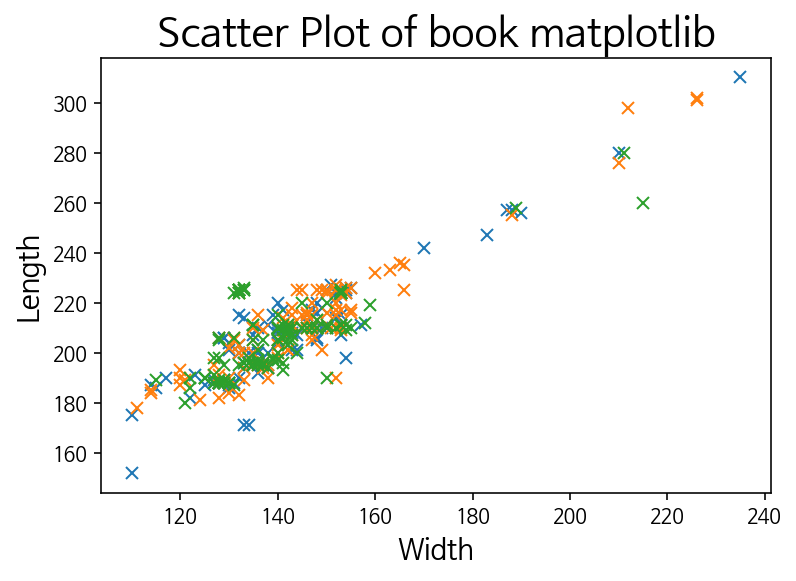

In [34]:
groups = final_top3_df.groupby('category')
plt.figure(figsize=(24,16))
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.width,
           group.length,
           marker='x',
           linestyle='',
           label=name)
    
#ax.legned(fontsize=12, loc='uppter left')
plt.title('Scatter Plot of book matplotlib', fontsize=20)
plt.xlabel('Width', fontsize=14)
plt.ylabel('Length', fontsize=14)
plt.show()

### 증명 1: 에세이, 인문, 소설 간에는 사이즈가 크게 중요하지 않다
#### 주로 책 제작 사이즈는 130-160 * 190-220

### 가설 2: 주요 출판사일수록 많은 리뷰 수를 가질 것이다

### 출판사 순위
#### 2018년 매출액 기준
- 1위 위즈덤하우스미디어그룹 :  339억원(전년 대비 22.3% 증가)
- 2위 시공사 : 262억원
- 3위 문학동네 : 253억원
- 4위 북이십일 : 249억원
- 5위 김영사 : 215억원
#### 2018년 영업이익 기준
- 1위 민음사 : 38억원(영업이익률 : 23.6%)
- 2위 웅진씽크빅(단행본) : 27억원
- 3위 북이십일 :  26억원
- 4위 문학동네 : 21억 8000만원
- 5위 도서출판 길벗 : 21억 3000만원
    
#### 69개 출판사의 지난해 총매출액 :  5조 528억원(전년대비 0.9%, 457억원 증가)
- 10곳 중 4곳은 매출 감소
- 학습지 부문에서 마이너스 성장(-3.2%)
- **위즈덤하우스미디어그룹 매출 1위였지만 영업적자도 19억원으로 1위**



In [65]:
df_final_bestsellors = pd.read_csv("./df_final_bestsellors.csv")

In [66]:
df_novel = df_final_bestsellors[df_final_bestsellors["category"] == 1]

In [67]:
len(df_novel["publisher"].unique())

44

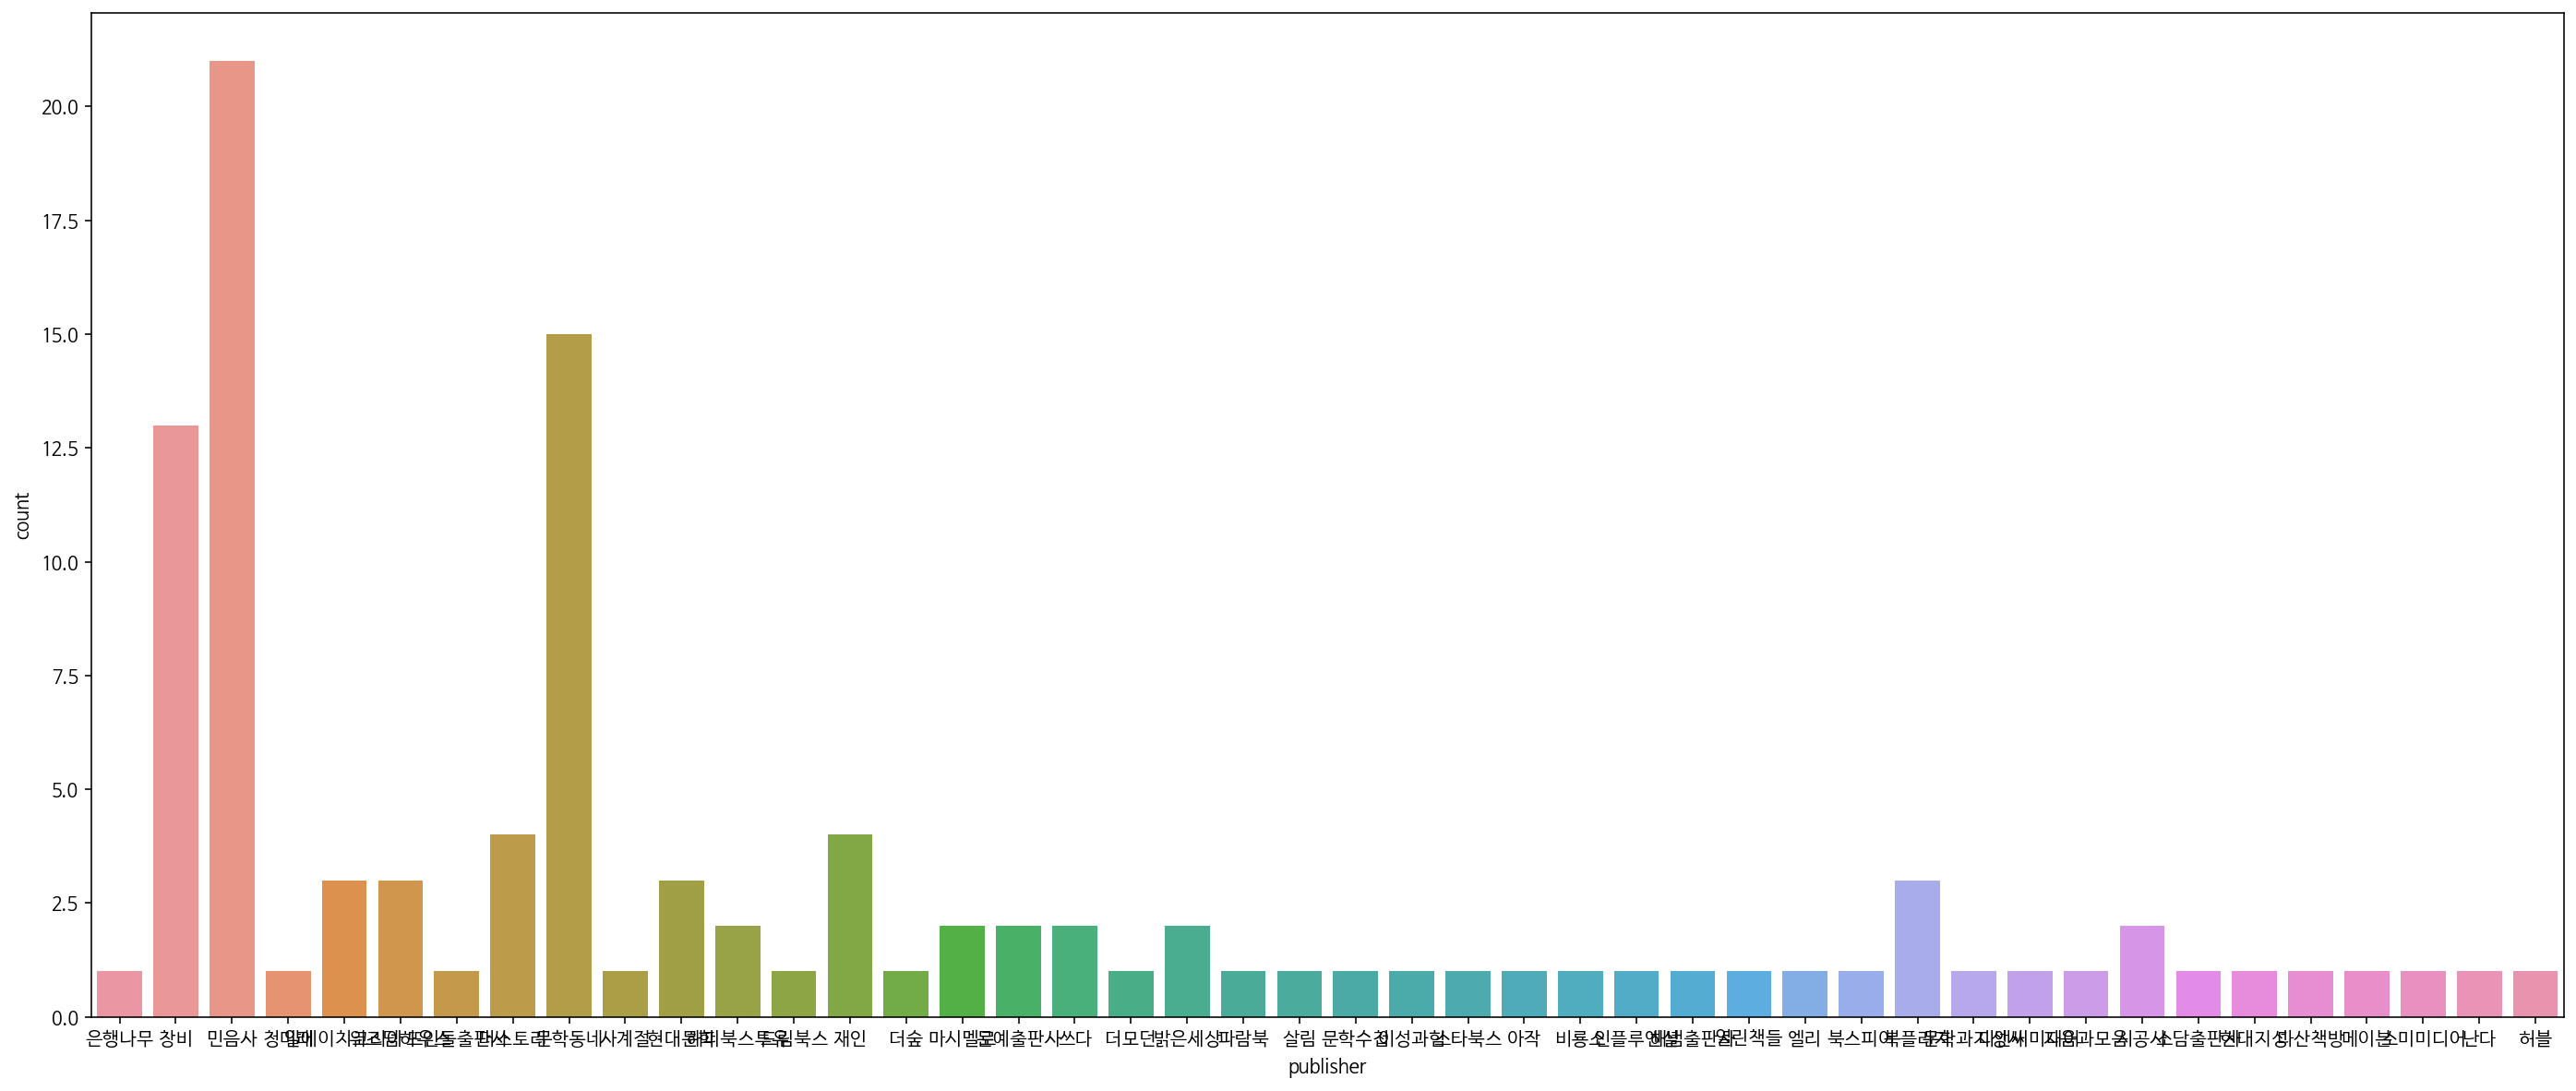

In [70]:
dist_publisher_novel = df_novel.reset_index().drop('index', axis=1)
plt.figure(figsize=(24, 10))
sns.countplot(x='publisher', data=dist_publisher_novel)
plt.show()

In [44]:
df_publisher = df_novel.groupby('publisher').size().reset_index()
df_publisher = df_publisher.rename(columns={0:'count'})
df_publisher_sort = df_publisher.sort_values('count', ascending=False)
df_publisher_sort = df_publisher_sort.reset_index().drop('index', axis=1)
df_publisher_sort.head(5)

,publisher,count
0,민음사,21
1,문학동네,15
2,창비,13
3,재인,4
4,더스토리,4


In [45]:
df_publisher_sort.describe()

,count
count,44.000000
mean,2.500000
std,3.979599
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,21.000000


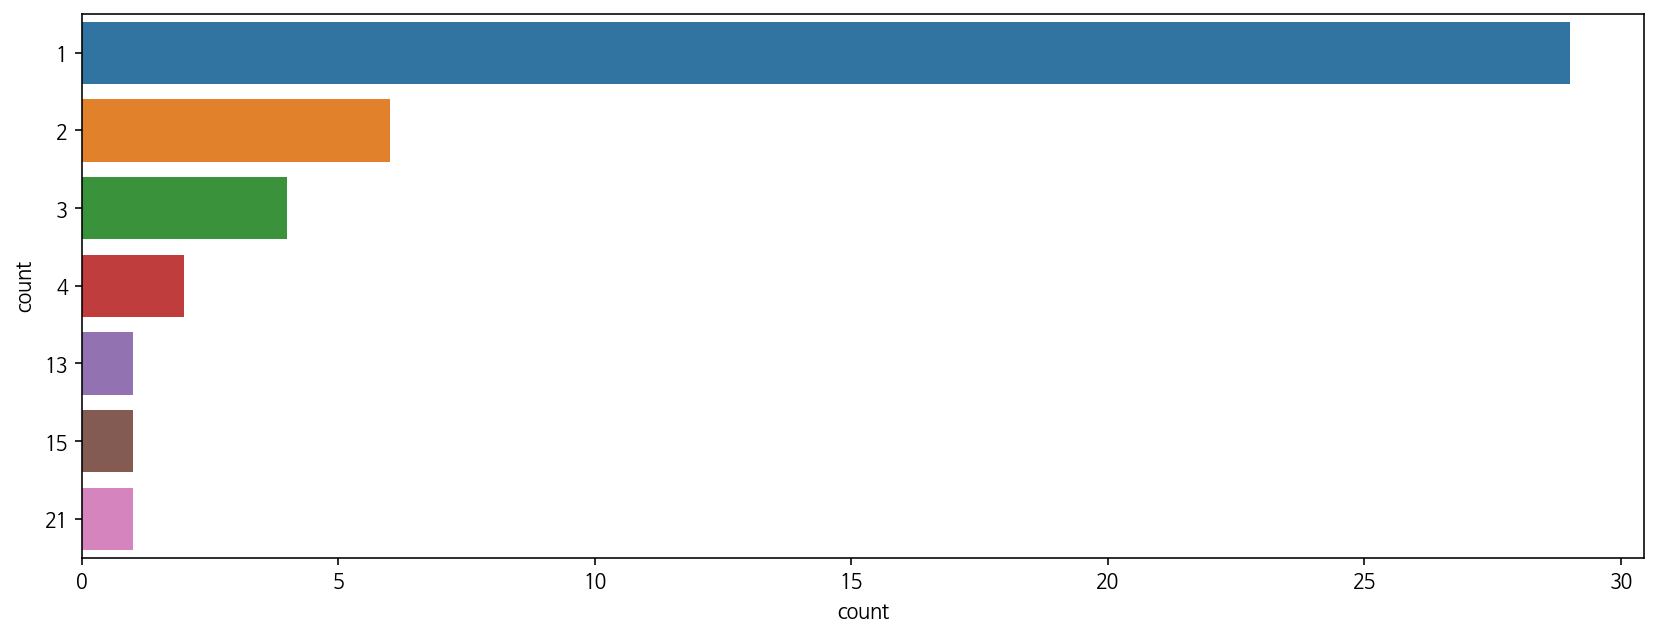

In [46]:
plt.figure(figsize=(14, 5))

sns.countplot(y='count', data=df_publisher_sort)

plt.show()

In [47]:
# 베스트셀러 순위에 1개 밖에 못 올린 출판사 개수 29개
len(df_publisher_sort[df_publisher_sort["count"] == 1])

29

In [49]:
# 베스트셀러 순위에 2개 밖에 못 올린 출판사 개수 6개
len(df_publisher_sort[df_publisher_sort["count"] == 2])

6

In [54]:
# 베스트셀러 순위에 2개 올린 출판사 개수 3개
df_publisher_sort[df_publisher_sort["count"] == 4]

,publisher,count
3,재인,4
4,더스토리,4


In [53]:
# 고전 소설을 작은 사이즈로 제작, 인기
df_novel[df_novel["publisher"] == "더스토리"]

,category,ranking,seogi_nl_clear,ISBN,title_x,author,publisher,price_x,width,length,thick,weight,page(쪽),grade,grade_count,summary_x,review,corpus
187,1,127,03810,9791164452323,한중록(1795년 오리지널 초판본 표지디자인),혜경궁 홍씨,더스토리,14800,135,194,39,539,400,4.0,1,"[내용 소개]왕이 되었으면 가장 위대했을 군주 사도세자와 영조와의 갈등,화려한 조선...",좋아요~~,"[내용 소개]왕이 되었으면 가장 위대했을 군주 사도세자와 영조와의 갈등,화려한 조선..."
292,1,85,03860,9791159039690,어린왕자(초판본)(1943년 오리지널 초판본 표지디자인),생텍쥐페리,더스토리,9800,136,195,17,280,150,56.0,14,"세상에서 가장 순수한 영혼, 《어린 왕자》 오리지널 초판본 표지디자인!생텍쥐페리는 ...",지금 읽으면 또 다른 느낌일 것 같아요. 마저영 다시 읽어봐도 좋은 소설 아름다운 ...,"세상에서 가장 순수한 영혼, 《어린 왕자》 오리지널 초판본 표지디자인!생텍쥐페리는 ..."
337,1,30,03860,9791164452125,페스트(초판본)(1947년 오리지널 초판본 표지디자인),알베르 카뮈,더스토리,13800,133,196,32,557,432,60.0,17,"《페스트》는 《이방인》 《시시포스의 신화》 등으로 널리 알려진, 노벨 문학상 수상 ...",재미있고 좋은 책입니다. 현상황에 어울리는 책이네요 코로나19로인한 대한민국의 위기...,"《페스트》는 《이방인》 《시시포스의 신화》 등으로 널리 알려진, 노벨 문학상 수상 ..."
349,1,8,03850,9791159036514,데미안(리커버 한정판)(초판본)(1919년 오리지널 초판본 패브릭 에디션),헤르만 헤세,더스토리,12000,136,196,22,409,248,212.0,54,20세기 독일 문학가들 가운데 우리나라 독자들에게 가장 잘 알려진 작가를 꼽으라고 ...,청소년기에 내가 읽던 책을 아이도 읽네요.\r\n자아찾기.청소년기 필독서 어린 시절...,20세기 독일 문학가들 가운데 우리나라 독자들에게 가장 잘 알려진 작가를 꼽으라고 ...


In [55]:
# 일본 소설, 유명 작가 히가시노 게이고를 위주로 출판
df_novel[df_novel["publisher"] == "재인"]

,category,ranking,seogi_nl_clear,ISBN,title_x,author,publisher,price_x,width,length,thick,weight,page(쪽),grade,grade_count,summary_x,review,corpus
200,1,89,03830,9788990982872,환야. 2,히가시노 게이고,재인,17800,137,196,41,544,444,48.0,12,“비록 그녀와의 밤이 환상일지라도…….”한신 아와지 대지진에서 밀레니엄 전야까지세기...,잘 읽겠습니다. 절판이라 중고로 구입해서 읽었었는데 새로 나와서 다시 구입했어요 백...,“비록 그녀와의 밤이 환상일지라도…….”한신 아와지 대지진에서 밀레니엄 전야까지세기...
285,1,94,03830,9788990982704,용의자 X의 헌신,히가시노 게이고,재인,16800,139,198,38,561,448,53.0,14,히가시노 게이고 문학의 정수로 일컬어지는 추리 소설 『용의자 X의 헌신』. 일본 문...,한번읽기시작하면 궁금해서 계속읽게되는 책이네요~ 추리소설좋아하면 꼭읽어보세요~ 영화...,히가시노 게이고 문학의 정수로 일컬어지는 추리 소설 『용의자 X의 헌신』. 일본 문...
290,1,73,03830,9788990982865,환야. 1,히가시노 게이고,재인,17800,138,195,46,620,520,71.0,18,히가시노 게이고의 장편소설『환야』제1권. 1995년 1월 일본을 강타한 한신 아와지...,재밌어요 정말 재미있게 읽었어요. 좋아하는 작가님입니다. 어제 도착해서 재미있게 읽...,히가시노 게이고의 장편소설『환야』제1권. 1995년 1월 일본을 강타한 한신 아와지...
307,1,62,03830,9788990982575,가면산장 살인사건,히가시노 게이고,재인,14800,130,202,30,450,336,150.0,42,히가시노 게이고의 소설 『가면산장 살인사건』. 저자와 독자가 아슬아슬한 두뇌 싸움을...,조금은 예상이 가는 트릭 진짜 재미있었어요! 한 절반쯤부터 책을 놓을수가 없더라고요...,히가시노 게이고의 소설 『가면산장 살인사건』. 저자와 독자가 아슬아슬한 두뇌 싸움을...


In [56]:
# 베스트셀러 순위에 2개 올린 출판사 개수 3개
df_publisher_sort[df_publisher_sort["count"] == 3]

,publisher,count
5,현대문학,3
6,위즈덤하우스,3
7,북플라자,3
8,알에이치코리아,3


In [28]:
final_top3_df = pd.read_csv("./fianl_top3_df.csv")

In [57]:
# 단행본으로 가장 많은 리뷰 수 top5: 페스트(56) > 데미안(54) > 아몬드(54) > 지쳤거나 좋아하는 게 없거나(53) > 김지영(51)
final_top3_df['grade_count'].sort_values(ascending=False)

241    56
237    54
242    54
115    53
204    51
       ..
308     2
328     1
153     1
154     1
162     1
Name: grade_count, Length: 347, dtype: int64

In [58]:
# 리뷰 수가 45개 이상인 책들을 추린다
df_lots_review = final_top3_df[final_top3_df['grade_count'] > 45]
#df_lots_review

In [59]:
# 출판사 기준으로 group화 하고, 출판사, 작품 제목, 저자 수, 총 점, 총 리뷰 수를 정렬한다
best_publisher = df_lots_review.groupby('publisher').agg({'title' : 'sum', 'author': 'count', 'grade' : 'sum', 'grade_count' : 'sum'})
#best_publisher['grade_count'].sort_values(ascending=False)
best_publisher.sort_values(by=['grade_count'], ascending=False)


#agg({'grade_count' : 'count','grade' : 'sum', 'review' : lambda x : ' '.join(x)})

,title,author,grade,grade_count
publisher,,,,
민음사,82년생 김지영페스트달과 6펜스호밀밭의 파수꾼데미안,5,927,251
시공사,사서함 110호의 우편물날씨가 좋으면 찾아가겠어요(드라마 방영 기념 한정판),2,386,100
문학동네,여자로 살아가는 우리들에게개인주의자 선언,2,375,98
창비,아몬드,1,202,54
더스토리,데미안(초판본)(리커버 한정판),1,212,54
강한별,지쳤거나 좋아하는 게 없거나,1,116,53
비잉(Being),인생의 마지막 순간에서,1,174,50
진심의꽃한송이,참 소중한 너라서,1,198,50
웅진지식하우스,초예측,1,167,50


### 증명2: 리뷰 수로 본 강세 출판사
- 민음사, 시공사, 문학동네 는 다량의 작품을 베스트셀러로 만들고, 리뷰도 45개 이상인 책들이 여러 권이다
- 민음사는 <<82년생 김지영>> 외에 주로 고전으로 베스트셀러 자리를 차지한다
- 강한별, 흔 등 독립출판으로 에세이 분야에서 유명해진 저자들이 만든 개인 출판사도 베스트셀러 리뷰 강세를 보인다

### 결론: 주요 출판사일수록 많은 리뷰를 가지는 것 아니다(소설, 에세이, 인문 기준)
- 하지만, 주요 출판사 중 민음사가 단일권 기준 가장 많은 리뷰수를 가진 책이 2권이나 있고, 3권이 top5 안에 든다
- 이 중 데미안(더스토리), 페스트가 tvN <책 읽어드립니다>에 소개되었고, 그 홍보효과를 본 것으로 예상된다
- 주요 출판사가 아닌 작은 출판사이더라도 많은 리뷰 수를 모을 수 있다
- 중요한 건 작품에 독자들을 감동시킬 수 있는 공감대가 얼마나 있는지이다 

### 가설3: 소설분야 부가기호 기준 가장 많은 세부 장르는 한국소설일 것이다

In [62]:
df_novel_add_num = df_final_bestsellors[df_final_bestsellors["category"] == 1]

In [63]:
df_novel_add_num['seogi_nl_clear'].unique

<bound method Series.unique of 3      03810
4      03810
5      04850
6      04800
183    03840
       ...  
348    04800
349    03850
350    03830
351        [
352    03810
Name: seogi_nl_clear, Length: 110, dtype: object>

In [65]:
df_novel_add_num2 = df_novel_add_num.groupby('seogi_nl_clear').size().reset_index()
df_novel_add_num3 = df_novel_add_num2.rename(columns={0:'count'})
df_novel_add_num_sort = df_novel_add_num3.sort_values('count', ascending=False)
df_novel_add_num_sort2 = df_novel_add_num_sort.reset_index().drop('index', axis=1)
df_novel_add_num_sort2.head()

,seogi_nl_clear,count
0,03810,30
1,03840,20
2,03830,10
3,04800,9
4,04810,9


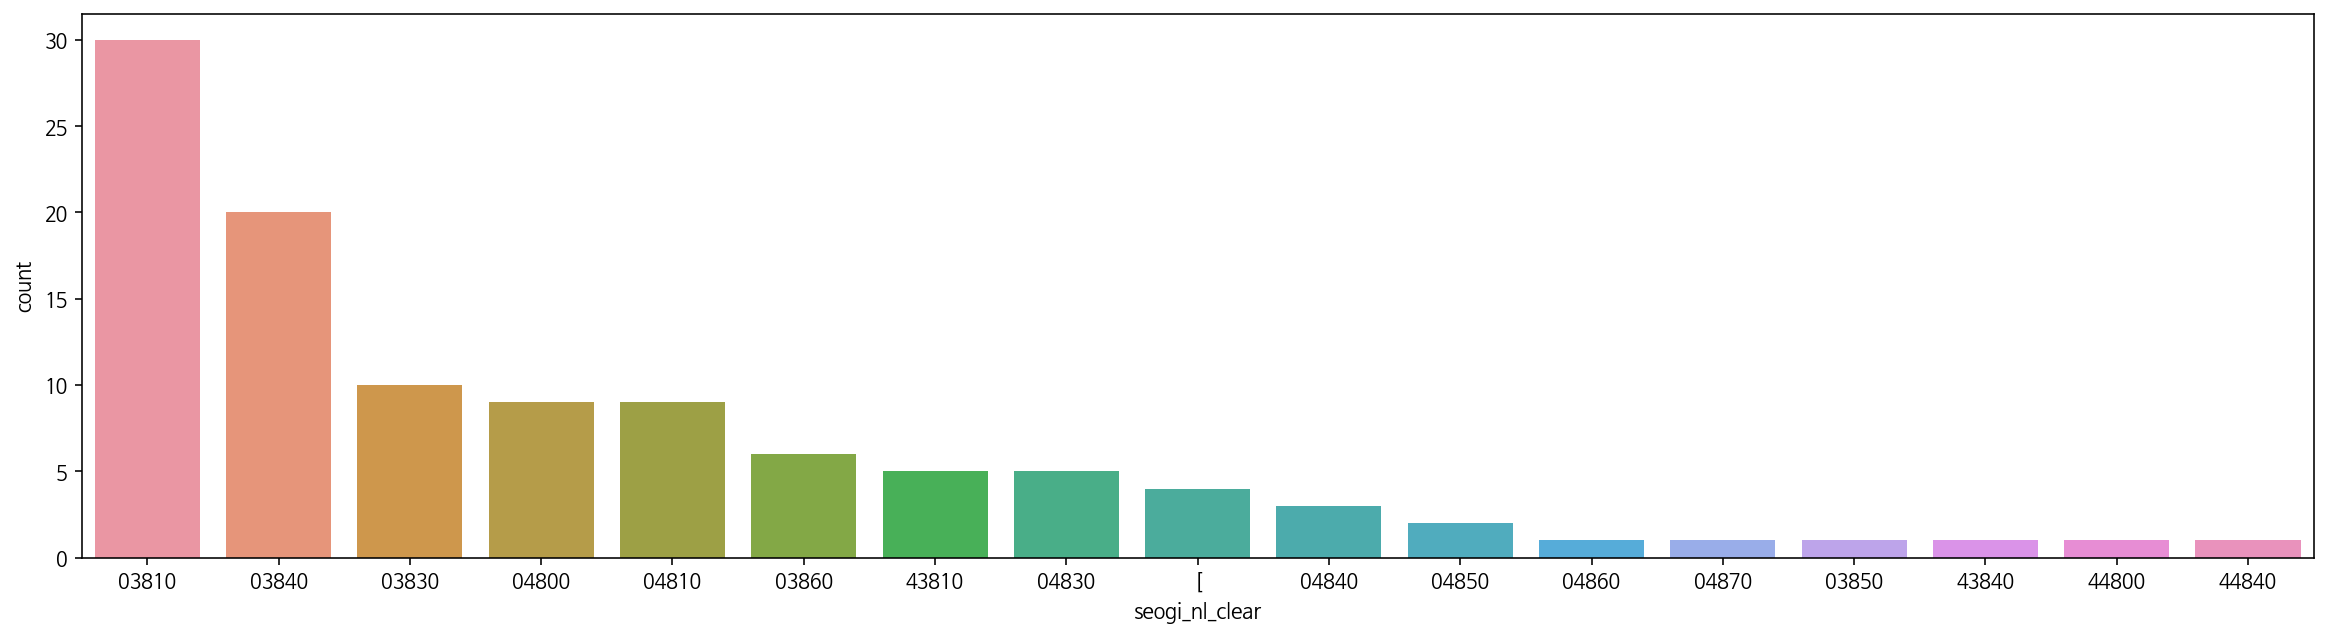

In [66]:
plt.figure(figsize=(20, 5))

sns.barplot(x='seogi_nl_clear', y='count', data=df_novel_add_num_sort2)

plt.show()

#### 부가기호 번호
- 03810: 한국문학 30권
- 03840: 영미문학 20권
- 03830: 일본문학 10권
- 04800: 문학 일반 세트 9권
- 04810: 한국문학 세트 9권

### 증명3: 한국문학이 가장 많고 그 뒤를 영미문학, 일본문학이 뒤따른다

## 머신러닝
### 워드 클라우드로 좋아하는 책 데이터 살펴보기

In [1]:
final_top3_df = pd.read_csv("./fianl_top3_df.csv", index_col=0)

In [2]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import nltk
from konlpy.corpus import kobill

### 카뮈_페스트
- tvN <책을 읽어드립니다> 에 소개
- 코로나 시기에 유럽의 흑사병과 관련된 이야기로 베스트셀러 1위 유지

In [3]:
novel = open('./카뮈_페스트.txt', encoding="utf-8").read()

#stopwords = set(text)
#stopwords.add("카뮈")
#stopwords

In [4]:
#wc = WordCloud(background_color='white', max_words=2000, stopwords=stopwords)
#wc = wc.generate(text)
#wc.words_

In [5]:
from konlpy.tag import Okt;
t = Okt()
tokens_ko = t.nouns(novel)
tokens_ko

['세기',
 '실존',
 '주의',
 '문학',
 '대표',
 '작가',
 '알베르',
 '카뮈',
 '소설',
 '페스트',
 '페스트',
 '비극',
 '현실',
 '속',
 '운명',
 '대결',
 '인간',
 '모습',
 '그린',
 '이',
 '작품',
 '세기',
 '문학',
 '기념비',
 '고전',
 '전염병',
 '폐쇄된',
 '도시',
 '재앙',
 '대응',
 '사람',
 '각기',
 '다른',
 '모습',
 '묘사',
 '인물',
 '재앙',
 '대처',
 '서로',
 '다른',
 '태도',
 '그',
 '모습',
 '통해',
 '절망',
 '것',
 '행복',
 '대한',
 '의지',
 '현실',
 '죽음',
 '앞',
 '희망',
 '것',
 '이',
 '세상',
 '대한',
 '반항',
 '임',
 '이야기',
 '이번',
 '한국어',
 '판',
 '우리나라',
 '최고',
 '불문학',
 '번역가',
 '선정',
 '김화영',
 '교수',
 '번역',
 '저자',
 '알베르',
 '카뮈',
 '알제리',
 '몽드비',
 '출생',
 '당시',
 '알제리',
 '프랑스',
 '식민지',
 '농업',
 '노동자',
 '아버지',
 '차',
 '세계대전',
 '중',
 '전사',
 '청각장애',
 '어머니',
 '가난',
 '속',
 '초등학교',
 '시절',
 '제르맹',
 '스승',
 '대학',
 '진학',
 '고학',
 '알제',
 '대학교',
 '철',
 '학과',
 '평생',
 '스승',
 '장',
 '그르니',
 '영향',
 '공산당',
 '가입',
 '그',
 '비판',
 '르포',
 '논설',
 '정치',
 '추방',
 '프랑스',
 '사상계',
 '문학계',
 '대표',
 '만',
 '말로',
 '지드',
 '사르트르',
 '샤르',
 '등',
 '교류',
 '본격',
 '작품',
 '활동',
 '몰입',
 '이방인',
 '발표',
 '주목',
 '작가',
 '노벨문학상',
 '수상한',
 '후',
 '최초',
 '본

In [6]:
ko = nltk.Text(tokens_ko, name="카뮈_페스트")

In [7]:
print(len(ko.tokens))
print(len(set(ko.tokens)))
ko.vocab()

582
351


FreqDist({'책': 23, '카뮈': 11, '알베르': 9, '것': 8, '문학': 7, '프랑스': 7, '작가': 6, '인간': 6, '작품': 6, '다른': 6, ...})

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import font_manager, rc
f_path = 'C://Windows/Fonts/malgun.ttf'

font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

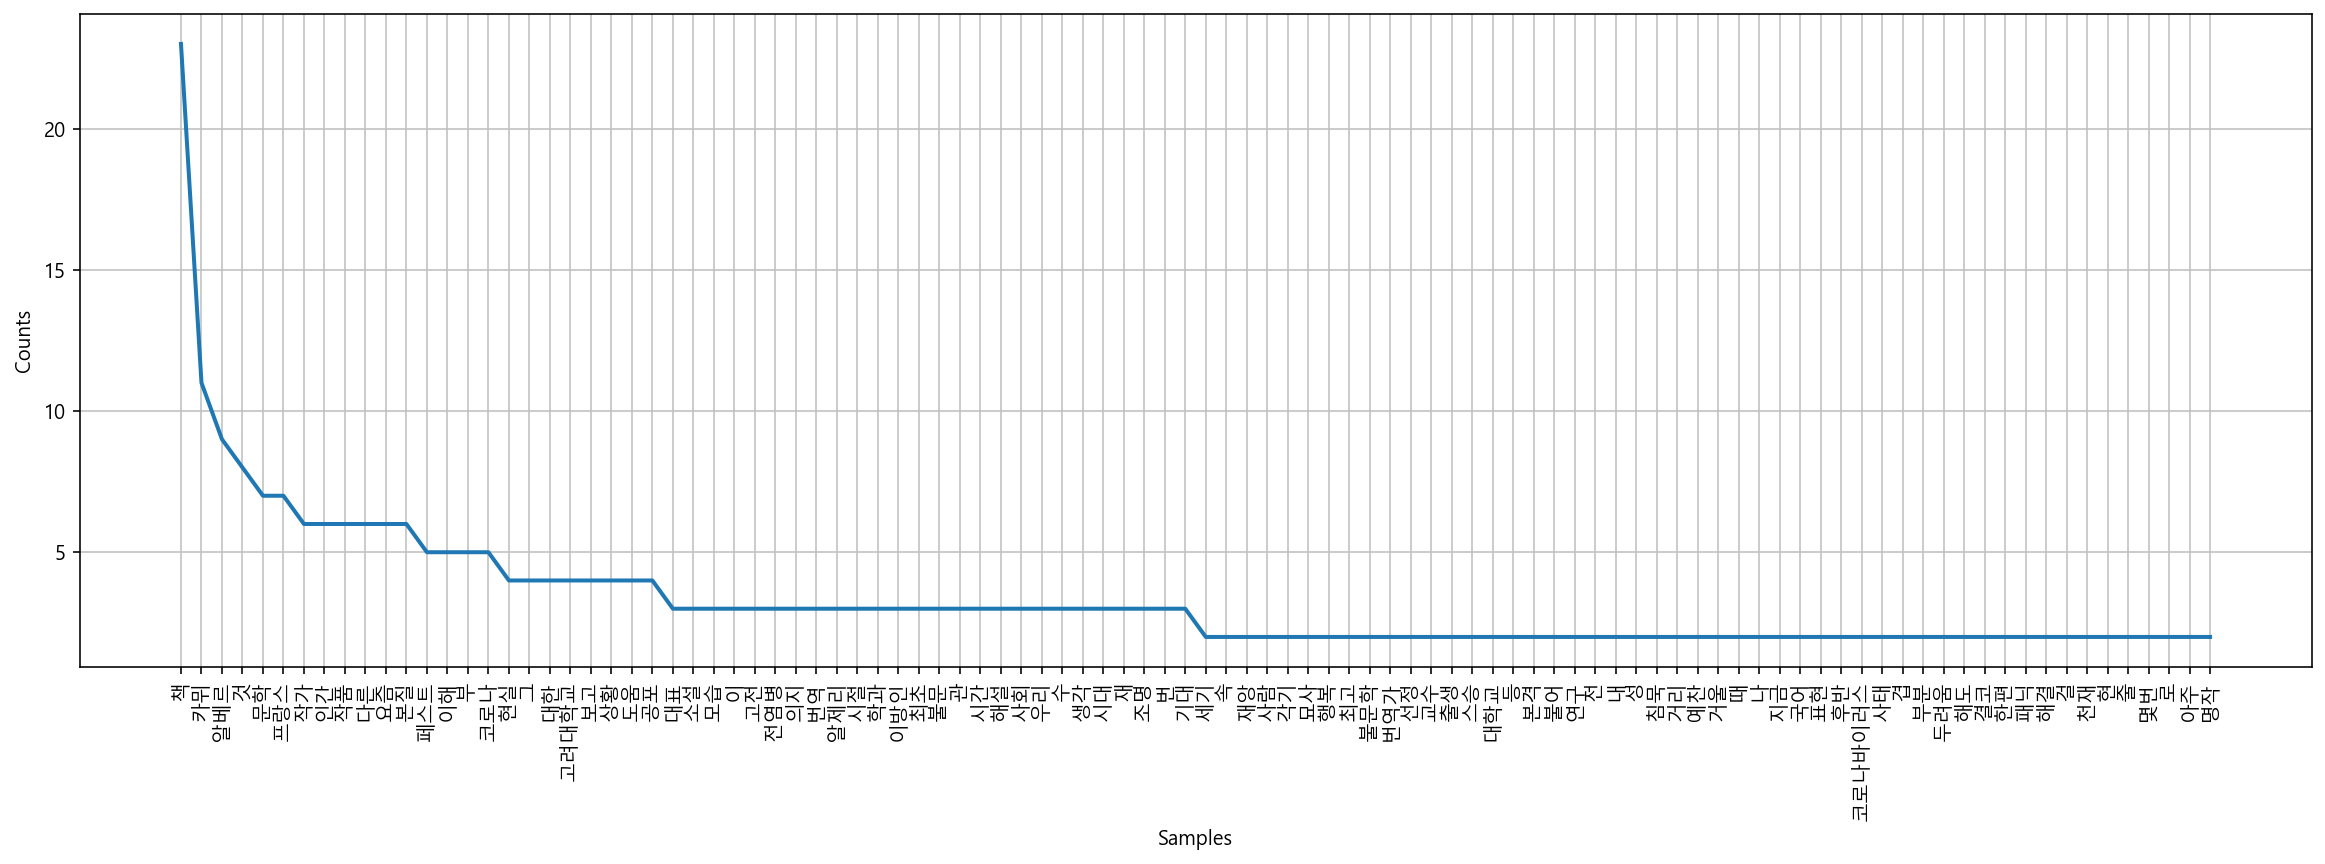

In [9]:
plt.figure(figsize=(20, 6))
ko.plot(100)
plt.show()

In [10]:
stop_words = ['책', '.', '(', ')', ',', "'", '%', '-', 'X', ').', 'x', '의', '자', '에', '안', '변', '호', '을', '이', '다', '만', '로', '가', '를', '것', '그', '이', '관', '수']

ko = [each_word for each_word in ko if each_word not in stop_words]
ko

['세기',
 '실존',
 '주의',
 '문학',
 '대표',
 '작가',
 '알베르',
 '카뮈',
 '소설',
 '페스트',
 '페스트',
 '비극',
 '현실',
 '속',
 '운명',
 '대결',
 '인간',
 '모습',
 '그린',
 '작품',
 '세기',
 '문학',
 '기념비',
 '고전',
 '전염병',
 '폐쇄된',
 '도시',
 '재앙',
 '대응',
 '사람',
 '각기',
 '다른',
 '모습',
 '묘사',
 '인물',
 '재앙',
 '대처',
 '서로',
 '다른',
 '태도',
 '모습',
 '통해',
 '절망',
 '행복',
 '대한',
 '의지',
 '현실',
 '죽음',
 '앞',
 '희망',
 '세상',
 '대한',
 '반항',
 '임',
 '이야기',
 '이번',
 '한국어',
 '판',
 '우리나라',
 '최고',
 '불문학',
 '번역가',
 '선정',
 '김화영',
 '교수',
 '번역',
 '저자',
 '알베르',
 '카뮈',
 '알제리',
 '몽드비',
 '출생',
 '당시',
 '알제리',
 '프랑스',
 '식민지',
 '농업',
 '노동자',
 '아버지',
 '차',
 '세계대전',
 '중',
 '전사',
 '청각장애',
 '어머니',
 '가난',
 '속',
 '초등학교',
 '시절',
 '제르맹',
 '스승',
 '대학',
 '진학',
 '고학',
 '알제',
 '대학교',
 '철',
 '학과',
 '평생',
 '스승',
 '장',
 '그르니',
 '영향',
 '공산당',
 '가입',
 '비판',
 '르포',
 '논설',
 '정치',
 '추방',
 '프랑스',
 '사상계',
 '문학계',
 '대표',
 '말로',
 '지드',
 '사르트르',
 '샤르',
 '등',
 '교류',
 '본격',
 '작품',
 '활동',
 '몰입',
 '이방인',
 '발표',
 '주목',
 '작가',
 '노벨문학상',
 '수상한',
 '후',
 '최초',
 '본격',
 '장편소설',
 '최초',
 '인간',
 '집필',
 '작업',
 

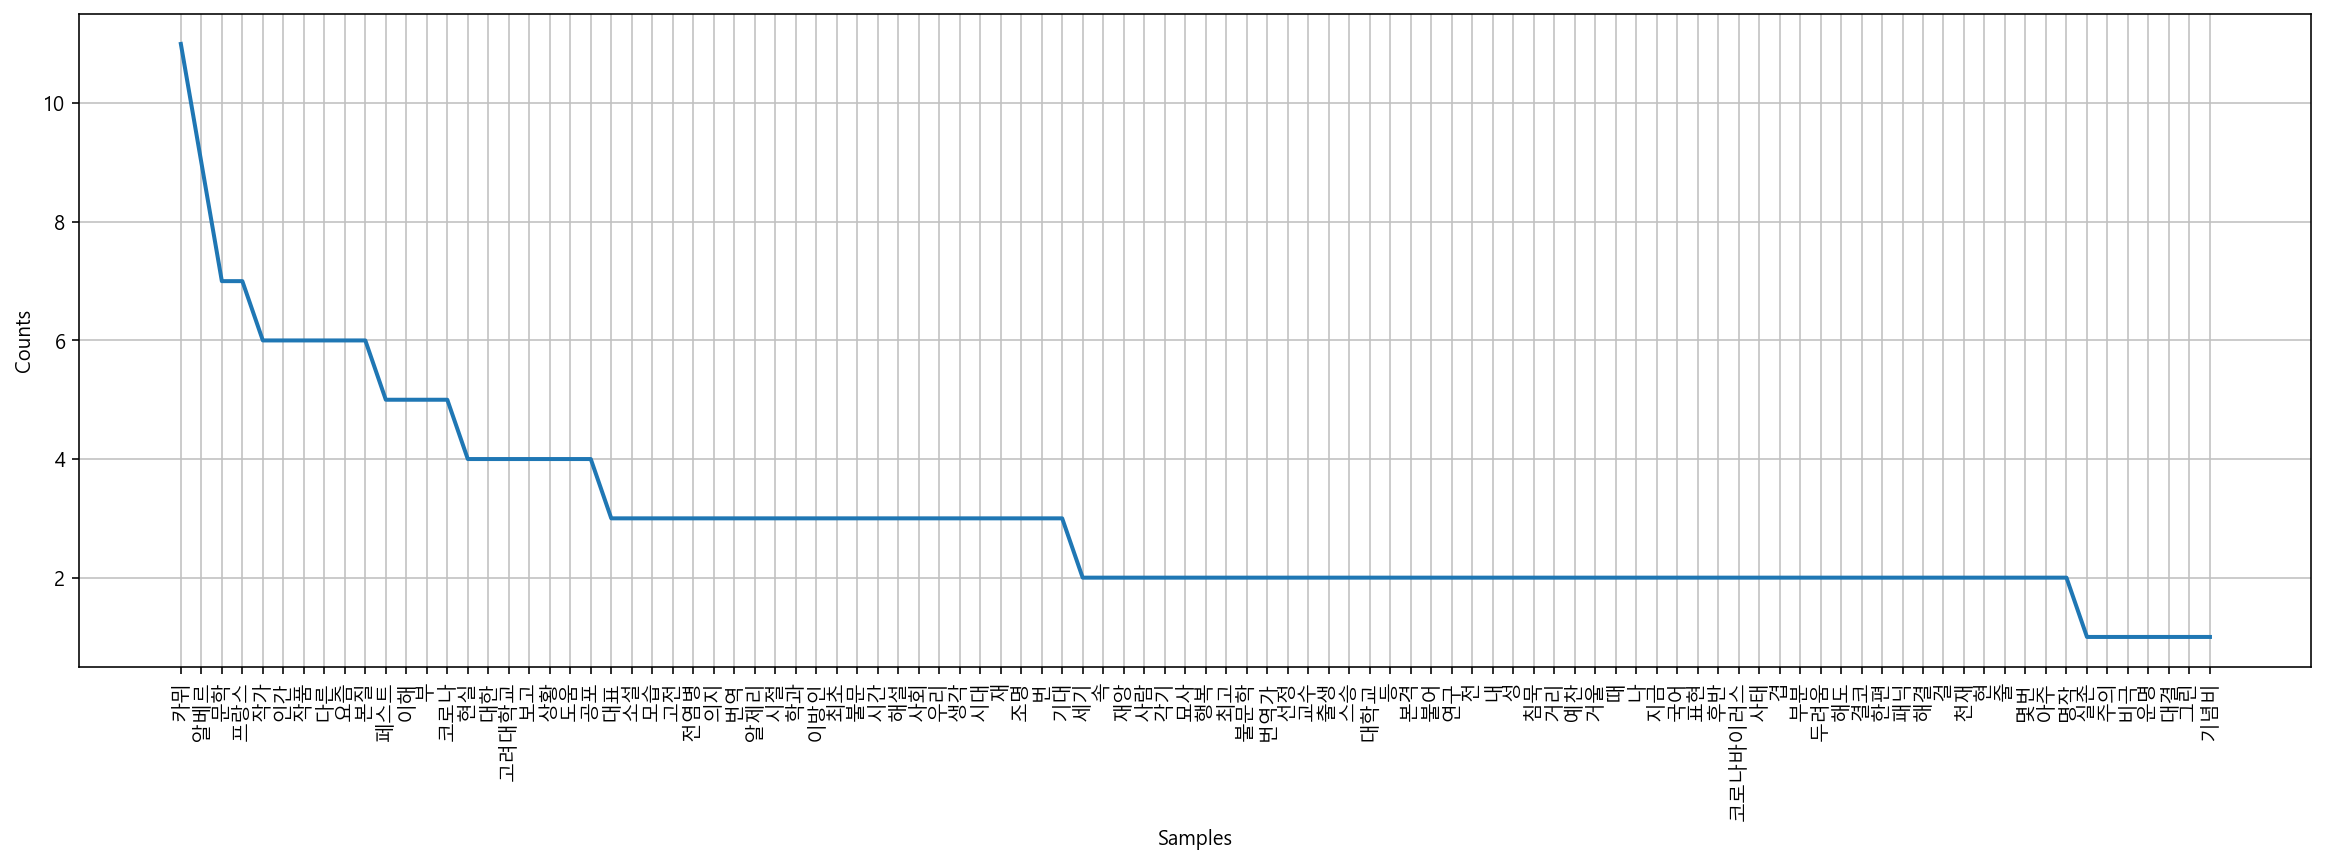

In [11]:
ko = nltk.Text(ko, name="카뮈_페스트")

plt.figure(figsize=(20, 6))
ko.plot(100)
plt.show()

### 코로나 단어가 14위에 오른 걸 보면, 리뷰데이터에 있던 코로나 언급이 많았다는 걸 알 수 있음 

In [12]:
ko.count('코로나')

5

In [13]:
ko.concordance('코로나')

Displaying 5 of 5 matches:
율리시즈 이별 시절 등 부 부 부 부 부 작품 해설 작가 연보 요즘 코로나 시기 명불허전 보고 구매 유행병 마주 인간 심리 사회 현상 묘사 감
하 각기 다른 사람 우리 볼 생각 퇴근 시간 시간 낭비 생각 게다가 코로나 뒤 지금 현실 꼭꼭 게 고전 두고두고 요즘 상황 번역 국어 표현 후
고전 두고두고 요즘 상황 번역 국어 표현 후반 해설 작품 이해 도움 코로나 때문 집콕 소름 정말 요즘 현실 듯 소설 코로나바이러스 사태 겹 부
질 해결 의지 공포 걸 시대 작가 천재 현 상황 이해 도움 줄 몇번 코로나 전염병 번역 국어 표현 후반 해설 작품 이해 도움 코로나바이러스 사
질 해결 의지 공포 걸 시대 작가 천재 현 상황 이해 도움 줄 몇번 코로나 전염병 시대 꼭 지금 더 굿 덕분 우리 내용 요즘 재 조명 번 보고


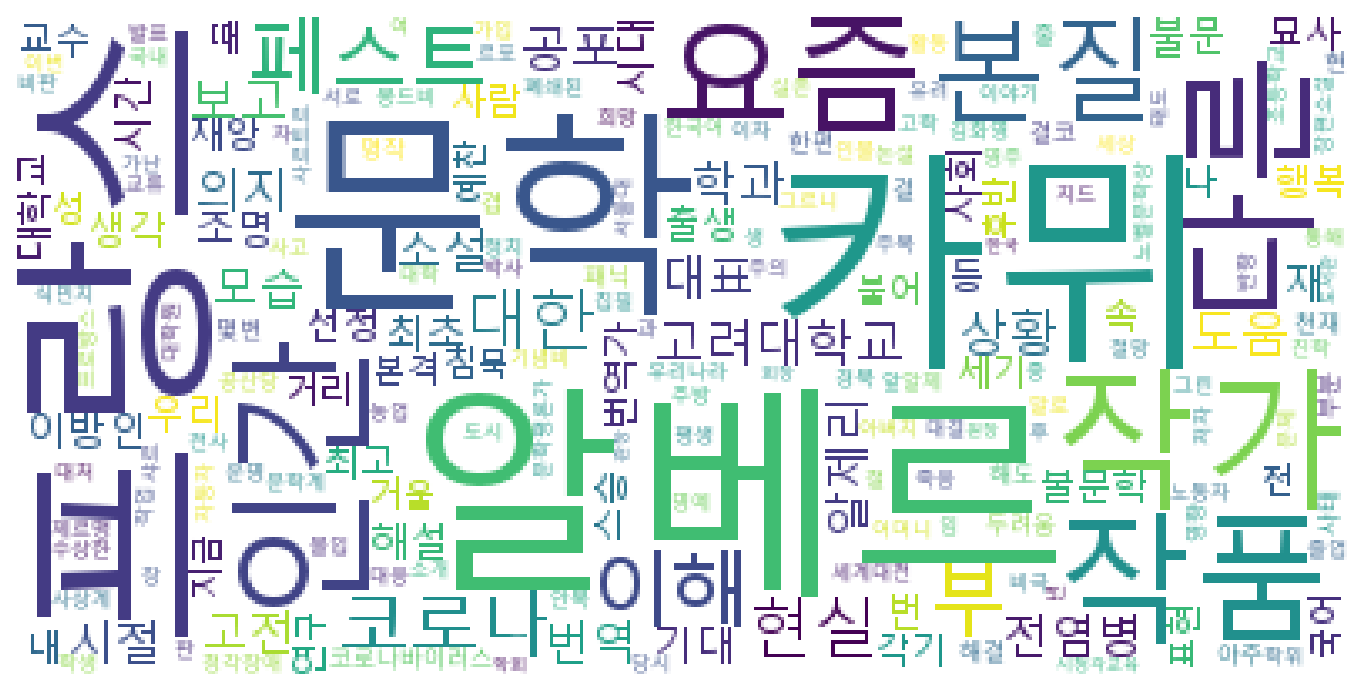

In [14]:
from wordcloud import WordCloud

data = ko.vocab().most_common(200)

wordcloud =  WordCloud(font_path=f_path, relative_scaling = 0.2, 
                      background_color='white',
                      ).generate_from_frequencies(dict(data))

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 헤세_데미안
- 좋아하는 책
- tvN <책을 읽어드립니다>에 소개
- 원래도 유명한 고전이라 저자권 기한도 만료되어 여러 출판사에서 출판
- 이중 '더스토리'란 출판사(미니 사이즈 책)에서 초판 디자인을 차용해 출간 해 '소장가치 높다'는 리뷰가 많음

In [15]:
final_top3_df[final_top3_df["title"] == "데미안"]

,category,seogi_nl_clear,ISBN,title,author,publisher,price,width,length,thick,weight,page(쪽),grade,grade_count,summary,review
340,5,04850,9788937460449,데미안,헤르만 헤세,민음사,8000,132,225,,NaN,240,188,49,현실에 대결하는 영혼의 발전을 담은 헤르만 헤세의 걸작 『데미안』. 독일 문학의 거...,주변과 유튜브에서도 많이 추천해주길래 첫 시작은 이책이다 하고\r\n제 돈주고 처음...


In [16]:
novel2 = open('./헤르만헤세_데미안.txt', encoding="utf-8").read()

In [17]:
from konlpy.tag import Okt;
t = Okt()
tokens_ko2 = t.nouns(novel2)
tokens_ko2

['세기',
 '독일',
 '문학가',
 '가운데',
 '우리나라',
 '독자',
 '가장',
 '작가',
 '꼽으',
 '단연',
 '헤르',
 '헤세',
 '일',
 '것',
 '내면',
 '탐구',
 '이자',
 '자아',
 '성찰',
 '대표',
 '작가',
 '헤르',
 '헤세',
 '휴머니즘',
 '지향',
 '고뇌',
 '청춘',
 '자연',
 '대한',
 '동경',
 '인간',
 '양면',
 '등',
 '작품',
 '도서',
 '출판',
 '더스토리',
 '헤르',
 '헤세',
 '탄생',
 '주년',
 '기념',
 '헤르',
 '헤세',
 '대표',
 '작',
 '데미안',
 '초',
 '호화',
 '패',
 '브릭',
 '양장',
 '제작',
 '패',
 '브릭',
 '특유',
 '색감',
 '감촉',
 '출판',
 '독일',
 '피셔',
 '출판사',
 '초',
 '판본',
 '표지',
 '디자인',
 '그대로',
 '소장',
 '가치',
 '한층',
 '또한',
 '실로',
 '정통',
 '사철',
 '제본',
 '통해',
 '책',
 '구성',
 '높이',
 '독일',
 '대표',
 '표지',
 '제작',
 '방식',
 '중',
 '하나',
 '초코',
 '박',
 '재현',
 '리지',
 '널',
 '초판',
 '본의',
 '품격',
 '가치',
 '헤르',
 '헤세',
 '전문',
 '번역자',
 '이자',
 '독일',
 '문학',
 '연구자',
 '역자',
 '깊이',
 '번역',
 '자서전',
 '철학',
 '헤르',
 '헤세',
 '문학',
 '감동',
 '고스',
 '란',
 '전',
 '것',
 '저자',
 '헤르',
 '헤세',
 '독일',
 '남부',
 '뷔르템베르크',
 '칼프',
 '목사',
 '아버지',
 '학계',
 '집안',
 '어머니',
 '밑',
 '신학교',
 '시험',
 '준비',
 '위해',
 '괴핑엔',
 '라틴어',
 '학교',
 '뷔르템베르크',
 '국가',
 '시험',
 '합격',
 '마울브론',

In [18]:
ko2 = nltk.Text(tokens_ko2, name="헤르만헤세_데미안")

In [19]:
print(len(ko2.tokens))
print(len(set(ko2.tokens)))
ko2.vocab()

633
348


FreqDist({'데미안': 25, '책': 19, '헤세': 12, '헤르': 9, '독일': 7, '표지': 7, '싱클레어': 7, '내면': 6, '자아': 6, '하나': 6, ...})

In [20]:
stop_words = ['책', '.', '(', ')', ',', "'", '%', '-', 'X', ').', 'x', '의', '자', '에', '안', '변', '호', '을', '이', '다', '만', '로', '가', '를', '것', '그', '이', '관', '수', '간', '앞', '때', '내', '준', '해']

ko2 = [each_word for each_word in ko2 if each_word not in stop_words]
ko2

['세기',
 '독일',
 '문학가',
 '가운데',
 '우리나라',
 '독자',
 '가장',
 '작가',
 '꼽으',
 '단연',
 '헤르',
 '헤세',
 '일',
 '내면',
 '탐구',
 '이자',
 '자아',
 '성찰',
 '대표',
 '작가',
 '헤르',
 '헤세',
 '휴머니즘',
 '지향',
 '고뇌',
 '청춘',
 '자연',
 '대한',
 '동경',
 '인간',
 '양면',
 '등',
 '작품',
 '도서',
 '출판',
 '더스토리',
 '헤르',
 '헤세',
 '탄생',
 '주년',
 '기념',
 '헤르',
 '헤세',
 '대표',
 '작',
 '데미안',
 '초',
 '호화',
 '패',
 '브릭',
 '양장',
 '제작',
 '패',
 '브릭',
 '특유',
 '색감',
 '감촉',
 '출판',
 '독일',
 '피셔',
 '출판사',
 '초',
 '판본',
 '표지',
 '디자인',
 '그대로',
 '소장',
 '가치',
 '한층',
 '또한',
 '실로',
 '정통',
 '사철',
 '제본',
 '통해',
 '구성',
 '높이',
 '독일',
 '대표',
 '표지',
 '제작',
 '방식',
 '중',
 '하나',
 '초코',
 '박',
 '재현',
 '리지',
 '널',
 '초판',
 '본의',
 '품격',
 '가치',
 '헤르',
 '헤세',
 '전문',
 '번역자',
 '이자',
 '독일',
 '문학',
 '연구자',
 '역자',
 '깊이',
 '번역',
 '자서전',
 '철학',
 '헤르',
 '헤세',
 '문학',
 '감동',
 '고스',
 '란',
 '전',
 '저자',
 '헤르',
 '헤세',
 '독일',
 '남부',
 '뷔르템베르크',
 '칼프',
 '목사',
 '아버지',
 '학계',
 '집안',
 '어머니',
 '밑',
 '신학교',
 '시험',
 '준비',
 '위해',
 '괴핑엔',
 '라틴어',
 '학교',
 '뷔르템베르크',
 '국가',
 '시험',
 '합격',
 '마울브론',
 '수도원',
 '학교',
 '

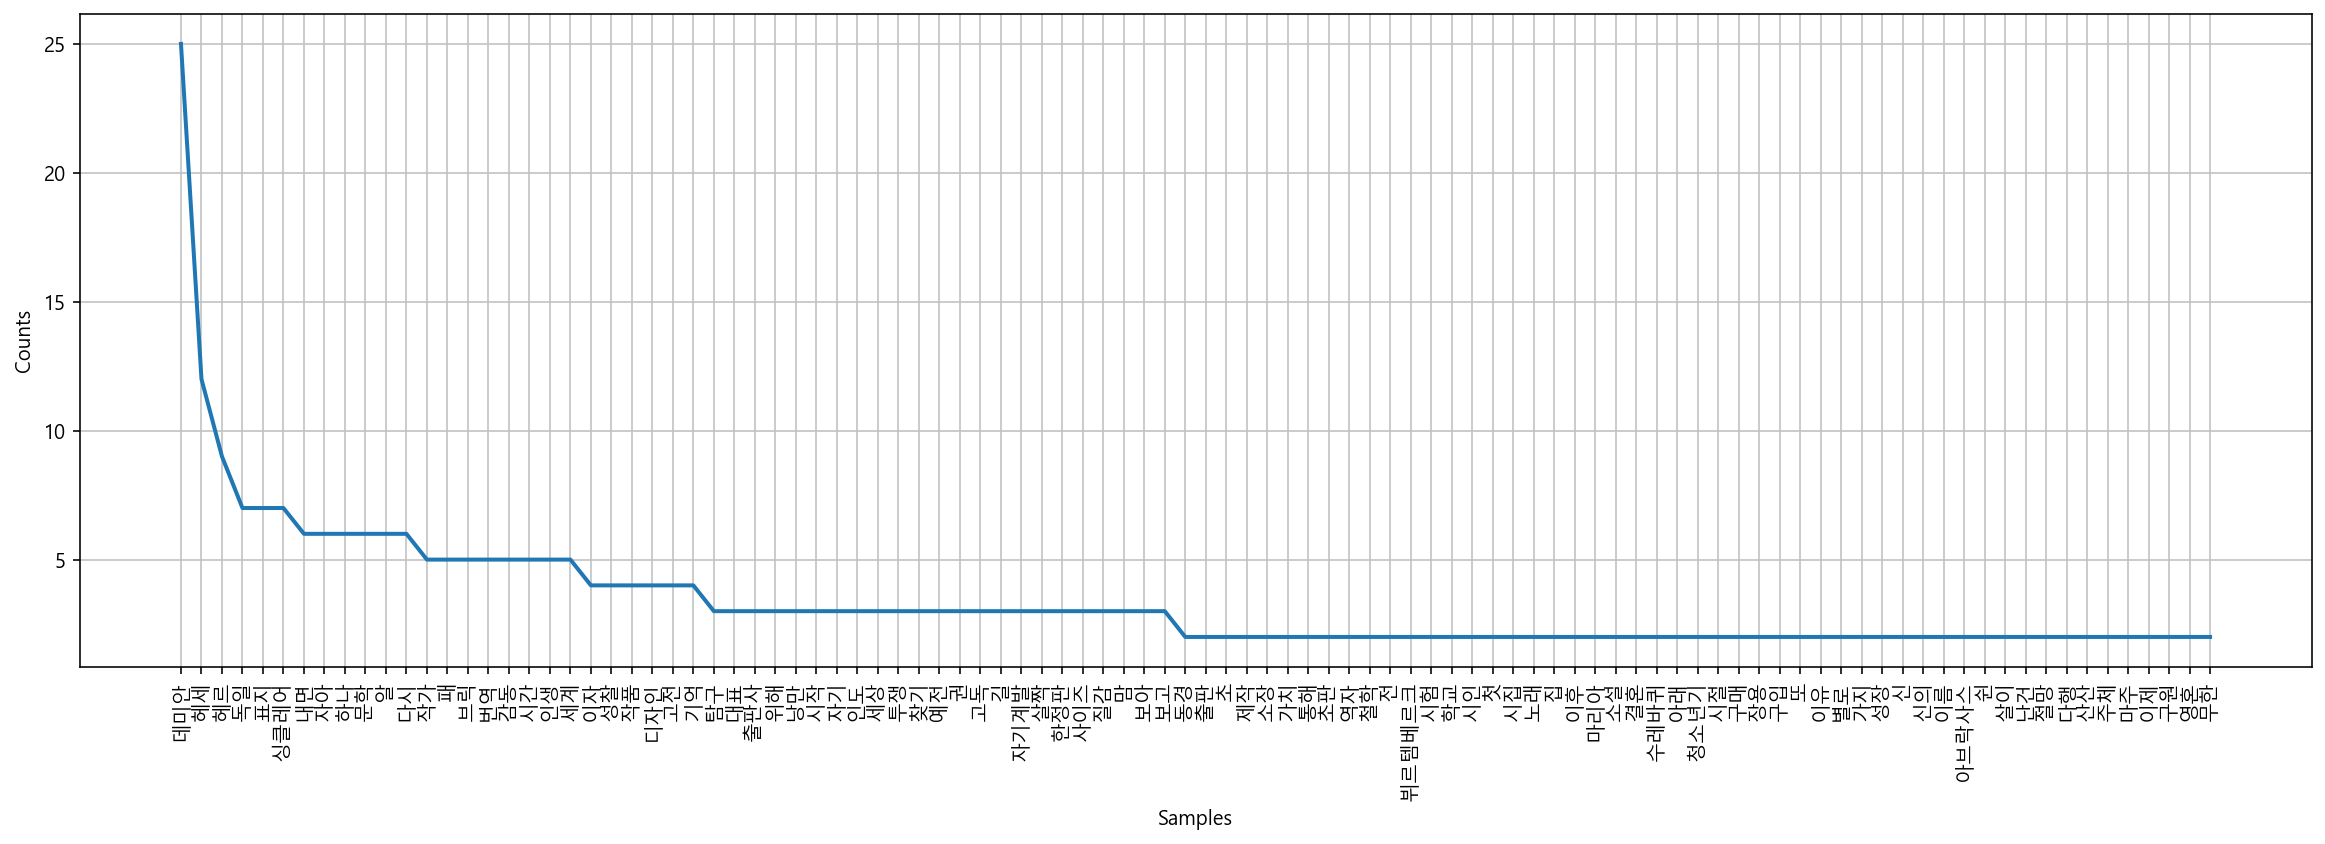

In [21]:
ko2 = nltk.Text(ko2, name="헤르만헤세_데미안")

plt.figure(figsize=(20, 6))
ko2.plot(100)
plt.show()

In [22]:
ko2.concordance('출판사')

Displaying 3 of 3 matches:
 호화 패 브릭 양장 제작 패 브릭 특유 색감 감촉 출판 독일 피셔 출판사 초 판본 표지 디자인 그대로 소장 가치 한층 또한 실로 정통 사철 
지 고급 지네 시간 사람 이유 음 다시금 작품 요 초판 장용 데미안 출판사 별로 권 가지 자아 성장 작가 내면 알 투쟁 알 세계 세계 신 신의
 무한 감사 바치 데미안 싱클레어 자아 찾기 베스트셀러 이유 데미안 출판사 별로 권 가지 자아 성장 작가 내면 알 투쟁 알 세계 세계 신 신의


In [23]:
ko2.concordance('표지')

Displaying 7 of 7 matches:
양장 제작 패 브릭 특유 색감 감촉 출판 독일 피셔 출판사 초 판본 표지 디자인 그대로 소장 가치 한층 또한 실로 정통 사철 제본 통해 구성
장 가치 한층 또한 실로 정통 사철 제본 통해 구성 높이 독일 대표 표지 제작 방식 중 하나 초코 박 재현 리지 널 초판 본의 품격 가치 헤
아 찾기 청소년기 필독 시절 나 공감 책표지 마음 데미안 불구 구매 표지 고전 장용 구입 예전 요즘 집 폰 제 권 데미안 예전 기억 또 전 
꿈 조언 정독 정말 새해 시작 학창시절 데미안 리 커버 다시 데미안 표지 고급 지네 시간 사람 이유 음 다시금 작품 요 초판 장용 데미안 출
싱클레어 자아 찾기 자기계발 성찰 번역 살짝 한정판 감동 고전 하나 표지 디자인 사이즈 패 브릭 질감 맘 인생 보아 자기계발 성찰 번역 살짝
질감 맘 인생 보아 자기계발 성찰 번역 살짝 한정판 감동 고전 하나 표지 디자인 사이즈 패 브릭 질감 맘 인생 보아 자기계발 성찰 번역 살짝
질감 맘 인생 보아 자기계발 성찰 번역 살짝 한정판 감동 고전 하나 표지 디자인 사이즈 패 브릭 질감 맘 인생 보아 데미안 대마 지금 데미안


In [24]:
ko2.concordance('자아')

Displaying 6 of 6 matches:
 우리나라 독자 가장 작가 꼽으 단연 헤르 헤세 일 내면 탐구 이자 자아 성찰 대표 작가 헤르 헤세 휴머니즘 지향 고뇌 청춘 자연 대한 동경
야곱 싸움 에바 부인 종말 시작 작품 해설 작가 연보 청소년기 아이 자아 찾기 청소년기 필독 시절 나 공감 책표지 마음 데미안 불구 구매 표
람 이유 음 다시금 작품 요 초판 장용 데미안 출판사 별로 권 가지 자아 성장 작가 내면 알 투쟁 알 세계 세계 신 신의 이름 아브락사스 데
원 데미안 시간 영혼 길 인도 헤세 무한 감사 바치 데미안 싱클레어 자아 찾기 베스트셀러 이유 데미안 출판사 별로 권 가지 자아 성장 작가 
안 싱클레어 자아 찾기 베스트셀러 이유 데미안 출판사 별로 권 가지 자아 성장 작가 내면 알 투쟁 알 세계 세계 신 신의 이름 아브락사스 데
원 데미안 시간 영혼 길 인도 헤세 무한 감사 바치 데미안 싱클레어 자아 찾기 자기계발 성찰 번역 살짝 한정판 감동 고전 하나 표지 디자인 


In [25]:
ko2.concordance('소장')

Displaying 2 of 2 matches:
특유 색감 감촉 출판 독일 피셔 출판사 초 판본 표지 디자인 그대로 소장 가치 한층 또한 실로 정통 사철 제본 통해 구성 높이 독일 대표 표
데미안 굿 데미안 보고 주문 예전 다시 나이 니 또 보고 구매 아들 소장 프로그램 보고 구입 청소년 시절 기억 감동 인생 싱클레어 손 동경 


In [26]:
ko2.concordance('가치')

Displaying 2 of 2 matches:
색감 감촉 출판 독일 피셔 출판사 초 판본 표지 디자인 그대로 소장 가치 한층 또한 실로 정통 사철 제본 통해 구성 높이 독일 대표 표지 제
표 표지 제작 방식 중 하나 초코 박 재현 리지 널 초판 본의 품격 가치 헤르 헤세 전문 번역자 이자 독일 문학 연구자 역자 깊이 번역 자서


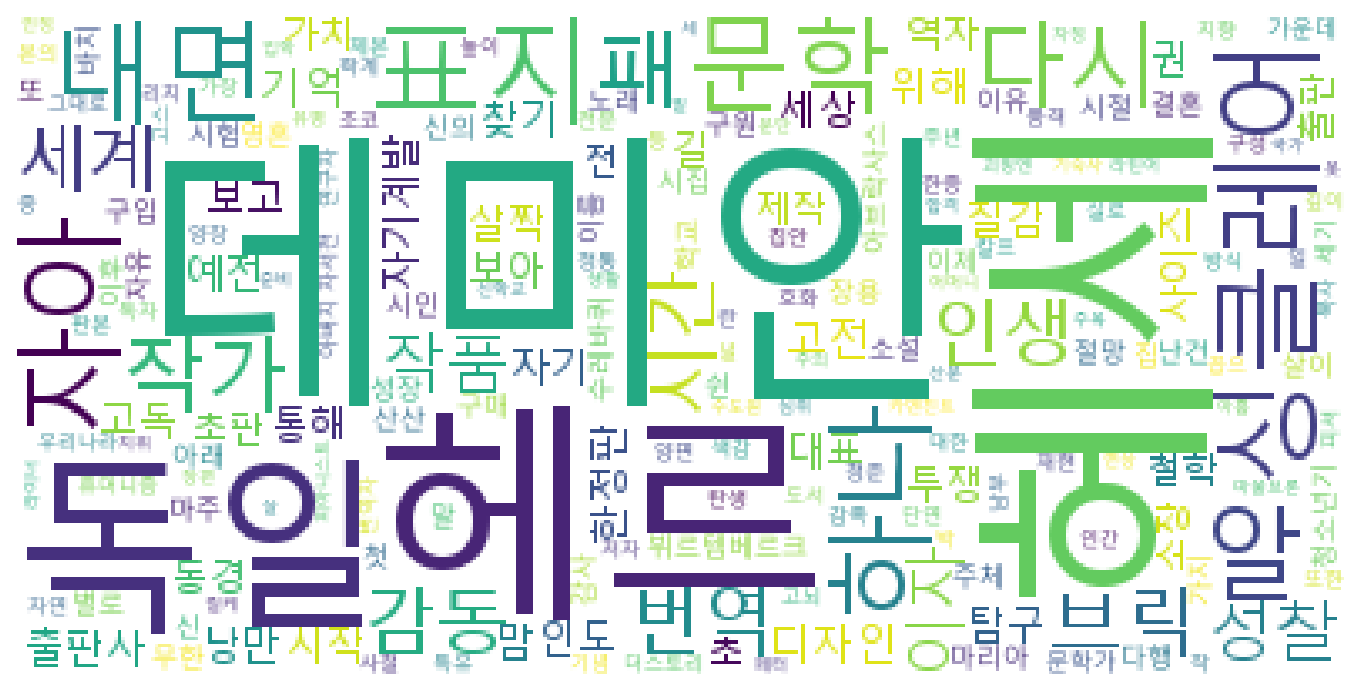

In [27]:
from wordcloud import WordCloud

data = ko2.vocab().most_common(200)

wordcloud =  WordCloud(font_path=f_path, relative_scaling = 0.2, 
                      background_color='white',
                      ).generate_from_frequencies(dict(data))

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 추천 시스템
- TfidVectorizer을 사용해, 책 소개/저자 소개/목차/리뷰 텍스트 데이터의 연관성을 학습
- 함수를 만들어 책 타이틀을 입력하면 거리가 가장 가까운 책들을 반환

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=0, stop_words=stop_words)
tfidf_matrix = tf.fit_transform(final_top3_df['author'])
tfidf_matrix

<347x451 sparse matrix of type '<class 'numpy.float64'>'
	with 609 stored elements in Compressed Sparse Row format>

In [40]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [41]:
titles = final_top3_df['title']
indices = pd.Series(final_top3_df.index, index=final_top3_df['title'])
indices['데미안']

340

In [42]:
cosine_sim[indices['데미안']]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [43]:
cosine_sim[indices['데미안']].shape

(347,)

In [44]:
list(enumerate(cosine_sim[indices['데미안']]))[:3]

[(0, 0.0), (1, 0.0), (2, 0.0)]

In [45]:
sim_scores = list(enumerate(cosine_sim[indices['데미안']]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores[:3]

[(237, 1.0), (340, 1.0), (0, 0.0)]

In [46]:
sim_scores = sim_scores[1:11]
book_indices = [i[0] for i in sim_scores]
titles.iloc[book_indices]

340                                       데미안
0                               여자 둘이 살고 있습니다
1                           꽃잎이 떨어져도 꽃은 지지 않네
2                                   엉덩이로 이름쓰기
3                                        피로사회
4                 한국사능력검정시험 심화 1, 2, 3급(2020)
5                                       어른의 일
6                                    감정에 체한 밤
7      달의 위로+마음이 마음에게+미안해 사랑해 고마워 리미티드 에디션 세트
8                                    윤동주 전 시집
Name: title, dtype: object

In [47]:
final_top3_df['corpus'] = (pd.Series(final_top3_df[['summary', 'review']].fillna('').values.tolist()).str.join(' '))
final_top3_df['corpus'][:3]

0    완벽한 싱글 라이프를 즐기던 두 여자, 김하나, 황선우. 4인 가족이 기준인 이 나...
1    《꽃잎이 떨어져도 꽃은 지지 않네》는 2003년 4월, 길상사 요사채에서 가진 법정...
2    책을 읽고 글을 쓴다.초등학교 방학 숙제로 첫 시집을 냈다.중학교 문예집에 수필 수...
Name: corpus, dtype: object

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_corpus = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=0, stop_words=stop_words)
tfidf_matrix_corpus = tf_corpus.fit_transform(final_top3_df['corpus'])
cosine_sim_corpus = linear_kernel(tfidf_matrix_corpus, tfidf_matrix_corpus)

titles = final_top3_df["title"]
indices = pd.Series(final_top3_df.index, index=final_top3_df['title'])

In [49]:
titles1 = final_top3_df['title']
indices1 = pd.Series(final_top3_df.index,index=final_top3_df['title'])

def corpus_recommendation(title):
    idx = indices1[title]
    sim_scores = list(enumerate(cosine_sim_corpus[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

### 데미안 : 
- 성장 소설 위주로 추천

In [50]:
corpus_recommendation("데미안")

237        데미안(초판본)(리커버 한정판)
242                      아몬드
217                      이방인
186                      비행운
248                  노르웨이의 숲
96                     여덟 단어
274                       모모
3                       피로사회
24     스물아홉 생일 1년 후 죽기로 결심했다
240                     동물농장
Name: title, dtype: object

### 죽고 싶지만 떡볶이는 먹고 싶어 : 
- 일상에 지친 사람들이 자신의 중심을 찾아가는 에세이 위주로 추천

In [51]:
corpus_recommendation("죽고 싶지만 떡볶이는 먹고 싶어")

112    내가 죽으면 장례식에 누가 와줄까(너나들이 리커버 에디션)
115                     지쳤거나 좋아하는 게 없거나
128             이미 어쩔 수 없는 힘듦이 내게 찾아왔다면
76          나는 어른이 되어서도 가끔 울었다(스페셜 에디션)
78                  무례한 사람에게 웃으며 대처하는 법
35                               너라는 계절
281                              보통의 존재
45                       아무것도 아닌 지금은 없다
123            언어의 온도(3주년 150만부 기념 에디션)
66                   이러지도 저러지도 못하는 당신에게
Name: title, dtype: object

### 재혼 황후: 
- 네이버 웹소설 인기작인 재혼 황후 단행본 출판으로, 왕과 이혼하는 황후 이야기
- 소설 위주로 추천하고, 이중 '한중록'이 들어간 것이 의외

In [52]:
corpus_recommendation("재혼 황후. 2(일반판)")

328                  재혼 황후. 3(일반판)
259                  재혼 황후. 1(일반판)
238                       녹나무의 파수꾼
170          지적 대화를 위한 넓고 얕은 지식. 2
214                참을 수 없는 존재의 가벼움
156                            한중록
262                            아가미
244                      목소리를 드릴게요
76     나는 어른이 되어서도 가끔 울었다(스페셜 에디션)
232                  사서함 110호의 우편물
Name: title, dtype: object

### 걷는 사람 하정우: 
- 배우 하정우가 걷기를 예찬하면 쓴 에세이
- 주로 에세이 위주로 추천해주었고, 이중 똑같이 배우 박정민 에세이 모음집인 '쓸 만한 인간'이 추천돼 신뢰성이 높아짐

In [53]:
corpus_recommendation("걷는 사람, 하정우")

116                  나는 나로 살기로 했다
245       신이 쉼표를 넣은 곳에 마침표를 찍지 말라
43                  나 같은 사람 또 있을까
124                     참 소중한 너라서
117    너에게만 좋은 사람이 되고 싶어(리커버 한정판)
184             내가 원하는 것을 나도 모를 때
14                        쓸 만한 인간
111                나에게 시간을 주기로 했다
17      태도의 말들: 사소한 것이 언제나 더 중요하다
284            타인의 시선을 의식해 힘든 나에게
Name: title, dtype: object

### 빨강 머리 앤:
- 소설을 각색한 긍정적인 멘트들을 편집한 책으로
- 긍정적인 제목을 가진 에세이들로 추천을 해줌

In [54]:
corpus_recommendation("빨강 머리 앤, 행복은 내 안에 있어")

203                             빨강 머리 앤
345                       고요할수록 밝아지는 것들
110                      실컷 울고나니 배고파졌어요
124                           참 소중한 너라서
184                   내가 원하는 것을 나도 모를 때
52                    완벽하지 않은 것들에 대한 사랑
83                            지금 이대로 좋다
69                       참 좋은 당신을 만났습니다
183    당신이 옳다(교보문고 단독 리커버)(찰스 장 아트 에디션)
117          너에게만 좋은 사람이 되고 싶어(리커버 한정판)
Name: title, dtype: object

### 역사의 쓸모
- 역사 와 관련 있는 서적들을 추천해줌, 4위부터는 인문서적 위주

In [55]:
corpus_recommendation("역사의 쓸모(윈터 에디션)")

99     한국사능력검정시험 기출500제 고급(1,2급)
171              한국사능력검정시험 심화(상)
172      한국사능력검정시험 심화(1,2,3급)(하)
88                        열두 발자국
184            내가 원하는 것을 나도 모를 때
132                  유시민의 글쓰기 특강
174                  설민석의 삼국지. 2
176                  설민석의 삼국지. 1
182                         사피엔스
31                   상처 받지 않는 영혼
Name: title, dtype: object

### 인간 실격
- 독특하고 다소 기괴한 사고관을 보여준 일본 작가 다자이 오사무 작품
- 일본 소설과 주로 어두운 내용의 책 추천

In [57]:
corpus_recommendation("인간 실격")

247                     용의자 X의 헌신
255                        노인과 바다
202                     가면산장 살인사건
267    눈먼 자들의 도시(100쇄 기념 스페셜 에디션)
217                           이방인
241                           페스트
164                  무엇이 인간을 만드는가
240                          동물농장
269                       잠옷을 입으렴
197               차라투스트라는 이렇게 말했다
Name: title, dtype: object

In [58]:
corpus_recommendation("잠옷을 입으렴")

127               밤은 이야기하기 좋은 시간이니까요
232                    사서함 110호의 우편물
243    날씨가 좋으면 찾아가겠어요(드라마 방영 기념 한정판)
222                    소설 보다: 봄 2020
128          이미 어쩔 수 없는 힘듦이 내게 찾아왔다면
245          신이 쉼표를 넣은 곳에 마침표를 찍지 말라
111                   나에게 시간을 주기로 했다
35                            너라는 계절
110                   실컷 울고나니 배고파졌어요
209                       브람스를 좋아하세요
Name: title, dtype: object

In [59]:
corpus_recommendation("날씨가 좋으면 찾아가겠어요(드라마 방영 기념 한정판)")

232                 사서함 110호의 우편물
269                       잠옷을 입으렴
127            밤은 이야기하기 좋은 시간이니까요
203                       빨강 머리 앤
52              완벽하지 않은 것들에 대한 사랑
45                 아무것도 아닌 지금은 없다
345                 고요할수록 밝아지는 것들
117    너에게만 좋은 사람이 되고 싶어(리커버 한정판)
223                그레구아르와 책방 할아버지
337                      호밀밭의 파수꾼
Name: title, dtype: object

### 햄릿
- 셰익스피어의 4대 비극
- 한국 역사의 비극이라고 할 수 있는 사도세자 이야기를 기록한 한중록이 추천된 점이 눈에 띔 
- 아버지의 복수를 하기 위해 자신의 삼촌을 죽인 햄릿 vs. 자신의 아들을 뒤주에 갇혀 죽게 한 아버지

In [60]:
corpus_recommendation("햄릿")

156                          한중록
337                     호밀밭의 파수꾼
234    세상의 주인(Lord Of The World)
241                          페스트
290                         동물농장
158                       절제의 기술
313                     백년을 살아보니
226                       멋진 신세계
92                    미움받을 용기. 2
182                         사피엔스
Name: title, dtype: object

In [61]:
corpus_recommendation("평균의 종말")

164        무엇이 인간을 만드는가
109              배움의 발견
181               팩트풀니스
74              평화의 어머니
165    당신의 어린 시절이 울고 있다
236       마음을 읽는 아이 오로르
154      생각은 어떻게 글이 되는가
167            정의란 무엇인가
163            공부머리 독서법
92           미움받을 용기. 2
Name: title, dtype: object

### 마음을 읽는 아이 오로르:
- 자폐아 이야기를 그림책으로 표현한 책
- 빨강 머리 앤, 어린 왕자와 같은 동화책이 추천

In [62]:
corpus_recommendation("마음을 읽는 아이 오로르")

235                  우리가 빛의 속도로 갈 수 없다면
286                갈매기에게 나는 법을 가르쳐준 고양이
203                             빨강 머리 앤
189                           어린왕자(초판본)
316                              평균의 종말
273                                 페인트
298                             자기 앞의 생
181                               팩트풀니스
264                           키싱 마이 라이프
183    당신이 옳다(교보문고 단독 리커버)(찰스 장 아트 에디션)
Name: title, dtype: object

### 프로이트의 의자:
- 심리학 위주의 책이 추천

In [63]:
corpus_recommendation("프로이트의 의자(10주년 기념 특별판)")

177    딸에게 보내는 심리학 편지(10만 부 기념 스페셜 에디션)
88                               열두 발자국
180                               명리심리학
118                               마음의 결
46                            존재만으로 빛나는
327                            초역 니체의 말
119                 곰돌이 푸, 행복한 일은 매일 있어
134                           인간 본성의 법칙
312                       나를 아프게 하지 않는다
183    당신이 옳다(교보문고 단독 리커버)(찰스 장 아트 에디션)
Name: title, dtype: object

### 앞으로 도전할 사항
- 책 소개 + 리뷰를 합친 텍스트 데이터(corpus)를 활용한 책 추천 시스템이 어느 정도 신뢰도를 보여줌
- 텍스트 데이터를 활용해 책 + 다른 산업 제품을 추천해주는 다양한 추천 시스템 개발